## Code

In [2]:
from keras.applications.resnet import ResNet50
import keras.backend as K
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Sequential, Model
from keras.layers import GlobalMaxPooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras_preprocessing.image import ImageDataGenerator
import sklearn.model_selection as skl
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix
import math
import random
from itertools import chain
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
%matplotlib inline


Using TensorFlow backend.


## Pre-processing of meta data

In [3]:
# Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in
                   glob(os.path.join('/data', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths),
      ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)


Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
39871,00010419_000.png,No Finding,0,10419,29,M,PA,2622,2991,0.143000,0.143000,NaN,/data/images_005/images/00010419_000.png
27730,00007212_016.png,Atelectasis|Consolidation,16,7212,49,M,AP,2500,2048,0.171000,0.171000,NaN,/data/images_004/images/00007212_016.png
111832,00030637_003.png,Emphysema|Pneumothorax,3,30637,49,M,PA,2021,2021,0.194311,0.194311,NaN,/data/images_012/images/00030637_003.png


In [4]:

def binarizeLabel(df, col_name):
    labels = np.unique(
        list(chain(*df[col_name].map(lambda x: x.split('|')).tolist())))
    labels = [x for x in labels if len(x) > 0]
    for c_label in labels:
        if len(c_label) > 1:  # leave out empty labels
            df[c_label] = df[col_name].map(
                lambda finding: 1.0 if c_label in finding else 0)
    return df, labels


In [5]:
all_xray_df, labels = binarizeLabel(all_xray_df, 'Finding Labels')

Below we can create a new column called 'pneumonia_class' that will allow us to look at images with or without pneumonia for binary classification.
We can also try to mark `inflitration` as pneumonia-positive to reduce false negatives, because infiltration is the most common comorbid disease. 

In [6]:

all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].apply(
    lambda x: 'Yes' if x == 1 else 'No')
# all_xray_df['pneumonia_class'] = all_xray_df['Infiltration'].apply(lambda x: 1 if x==1 else 0)

# Remove patients with age older than 100 years old
df = all_xray_df[(all_xray_df['Patient Age'] <= 100)]
df.sample(5)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
64962,00016042_000.png,Infiltration,0,16042,39,F,PA,2702,2529,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,No
104972,00028162_000.png,No Finding,0,28162,53,F,PA,2218,2542,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,No
63554,00015679_010.png,Consolidation,10,15679,65,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
92560,00023103_003.png,Infiltration,3,23103,30,F,PA,2992,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,No
35262,00009309_003.png,No Finding,3,9309,61,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,No


In [7]:
len(df[df['pneumonia_class']=='Yes']['Patient ID'].unique()), len(df['Patient ID'].unique())

(1008, 30802)

## Create training and testing data

### Split train-test-dataset based on unique patient ID
- Patients who are diagnosed positive for Pneumonia are selected and split into train and test dataset with a ratio of 80 to 20. Patients in the train and test dataset have no overlapping. 
- Fill up each dataset with negative cases: 50:50 +/- train dataset and 20:80 +/- in test dataset. 

Method: 
shuffle index and append list to train with 80% on train 

In [9]:
def create_splits(df, test_ratio=4):
    random.seed(2)
    print('The dataset consists of {} Pneumonia positive images, and {} negative images'.format(
        len(df[df['pneumonia_class'] == 1]), len(df[df['pneumonia_class'] == 0])))

    train_data, test_data = skl.train_test_split(df,
                                                 test_size=0.2,
                                                 stratify=df['Pneumonia'])
    pos_ind = train_data[train_data['pneumonia_class'] == 'Yes'].index.tolist()
    neg_ind = train_data[train_data['pneumonia_class'] == 'No'].index.tolist()
    # a balanced training dataset with a 50:50 ratio of positive and negative images
    neg_sample = random.sample(neg_ind, len(pos_ind))
    train_data = train_data.loc[pos_ind+neg_sample]

    vpos_ind = test_data[test_data['pneumonia_class'] == 'Yes'].index.tolist()
    vneg_ind = test_data[test_data['pneumonia_class'] == 'No'].index.tolist()
    # a validation dataset with a 20:80 ratio of positive and negative images
    vneg_sample = random.sample(vneg_ind, test_ratio*len(vpos_ind))
    test_data = test_data.loc[vpos_ind+vneg_sample]

    print('Train dataset consists of {} images, with {:0.1%} positive images ({}).'.format(
        len(train_data), len(pos_ind)/len(train_data), len(pos_ind)))
    print('Test dataset consists of {} images, with {:0.1%} positive images ({}).'.format(
        len(test_data), len(vpos_ind)/len(test_data), len(vpos_ind)))

    return train_data, test_data


In [8]:
# def create_unique_patient_splits(df, train_ratio=5, split_ratio=0.8):
#     random.seed(2)
#     ## Either build your own or use a built-in library to split your original dataframe into two sets 
#     ## that can be used for training and testing your model
#     ## It's important to consider here how balanced or im balanced you want each of those sets to be
#     ## for the presence of pneumonia
#     p_patients = df[df['Pneumonia']==1]
#     n_patients = df[df['Pneumonia']==0]

#     p_unique_patient = p_patients['Patient ID'].sort_values().unique().tolist()
#     n_unique_patient = n_patients['Patient ID'].sort_values().unique().tolist()
#     random.shuffle(p_unique_patient)
#     random.shuffle(n_unique_patient)
#     print('The dataset consists of {} Pneumonia positive images, and {} negative images'.format(len(p_patients), len(n_patients)))

#     p_train_ind = p_unique_patient[:int(split_ratio*len(p_unique_patient))]
#     p_test_ind = p_unique_patient[int(split_ratio*len(p_unique_patient)):]

#     # Positive images split
#     p_train = p_patients.loc[p_patients['Patient ID'].isin(p_train_ind)]
#     p_test = p_patients.loc[p_patients['Patient ID'].isin(p_test_ind)]

#     # Fill in negative images
#     n_train_id = [p for p in n_unique_patient if not p in p_test_ind]
#     n_train_ind = random.sample(n_patients.loc[n_patients['Patient ID'].isin(n_train_id)].index.tolist(), train_ratio*len(p_train))

#     n_test_id = [p for p in n_unique_patient if not p in (p_train_ind+n_train_id)]
#     n_test_ind = random.sample(n_patients.loc[n_patients['Patient ID'].isin(n_test_id)].index.tolist(), 4*len(p_test))

#     train_data = pd.concat([p_train, n_patients.loc[n_train_ind]])
#     test_data = pd.concat([p_test, n_patients.loc[n_test_ind]])
#     print('Train dataset consists of {} images, with {:0.1%} positive images ({}).'.format(len(train_data), len(p_train)/len(train_data), len(p_train)))
#     print('Test dataset consists of {} images, with {:0.1%} positive images ({}).'.format(len(test_data), len(p_test)/len(test_data), len(p_test)))
    
#     return train_data, test_data, len(p_train)/len(n_patients.loc[n_train_ind])

In [10]:
train_data, test_data = create_splits(df)

The dataset consists of 0 Pneumonia positive images, and 0 negative images
Train dataset consists of 2288 images, with 50.0% positive images (1144).
Test dataset consists of 1430 images, with 20.0% positive images (286).


## Mdel-building & training

### Image augmentation

In [11]:
@dataclass
class AugVars:
    rescale: float = 1./255.0
    horizontal_flip: bool = True
    vertical_flip: bool = False
    rotation_range: int = 10
    width_shift_range: float = 0.1
    height_shift_range: int = 0
    shear_range: float = 0.05
    zoom_range: float = 0.05
    brightness_range: tuple = (0.3, 0.9)
    preprocessing_function=preprocess_input
    def to_dict(self):
        return self.__dict__


In [12]:
def my_image_augmentation(valid_aug=False):

    if valid_aug == True:
        image_generator = ImageDataGenerator(rescale=1./255.0,
                                             preprocessing_function=preprocess_input)
    else:
        aug_vars = AugVars()
        image_generator = ImageDataGenerator(**aug_vars.to_dict())

    return image_generator


### Create generators using the output of `my_image_augmentation`

In [13]:
def make_train_gen(train_idg, train_data, x_col='path', y_col='pneumonia_class', target_size=(224, 224), batch_size=16, shuffle=True, seed=42):

    train_gen = train_idg.flow_from_dataframe(dataframe=train_data,
                                              directory=None,
                                              x_col=x_col,
                                              y_col=y_col,
                                              class_mode='binary',
                                              target_size=target_size,
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              seed=seed
                                              )

    return train_gen


def make_test_gen(test_idg, test_data, x_col='path', y_col='pneumonia_class', target_size=(224, 224), shuffle=False, seed=42):
    test_gen = test_idg.flow_from_dataframe(dataframe=test_data,
                                            directory=None,
                                            x_col=x_col,
                                            y_col=y_col,
                                            class_mode='binary',
                                            target_size=target_size,
                                            batch_size=len(test_data),
                                            shuffle=shuffle,
                                            seed=seed
                                            )
    return test_gen


In [14]:
train_idg = my_image_augmentation()
test_idg = my_image_augmentation(valid_aug=True)

In [15]:
train_gen = make_train_gen(train_idg, train_data)
test_gen = make_test_gen(test_idg, test_data)


Found 2288 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [16]:
# Validation data 
valX, valY = test_gen.next()

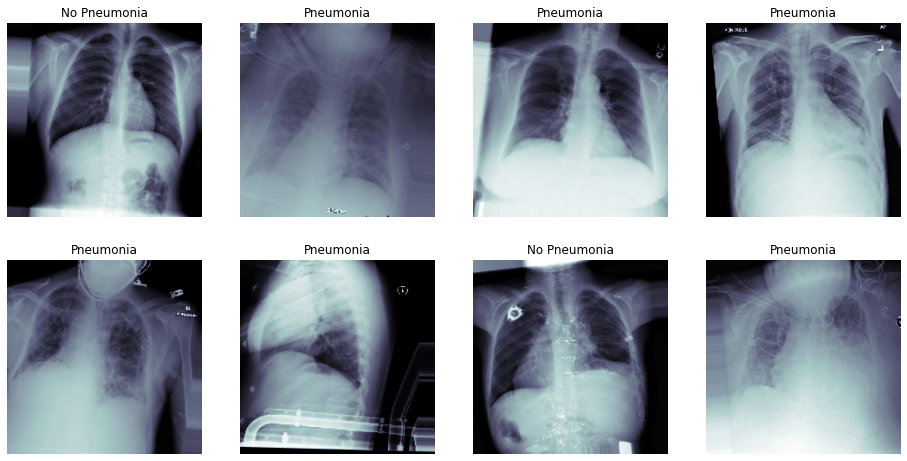

In [17]:
# Check samples for augmentation results

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16,8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1:
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

In [18]:
# def weighted_binary_crossentropy(weight_zero=1, weight_one=1):
#     def weighted_bce(y_true, y_pred):
#         b_ce = K.binary_crossentropy(y_true, y_pred)

#         weights = y_true * weight_one + (1 - y_true) * weight_zero
#         weighted_b_ce = weights * b_ce
#         return K.mean(weighted_b_ce)
#     return weighted_bce

# my_loss = weighted_binary_crossentropy(ratio, 1)

## Build pre-trained model using transfer learning 

In [19]:
def build_model(include_top=False, input_shape=(224, 224, 3), layer_of_interest='block5_pool', finetune=15):

    base_model = VGG16(include_top=include_top,
                       weights='imagenet',
                       input_shape=input_shape)

    if finetune > 0:
        for layer in base_model.layers[0:finetune]:
            layer.trainable = False
    else:
        for layer in base_model.layers:
            layer.trainable = True

    transfer_layer = base_model.get_layer(layer_of_interest)
    transfer_output = transfer_layer.output

    x = Flatten()(transfer_output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(1, activation='sigmoid')(x)

    model = Model(base_model.input, x)
    model.compile(optimizer=Adam(lr=1e-3),
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy'])
    model.summary()

    for l in model.layers:
        print('Layer {} Trainable {}'.format(l.name, l.trainable))

    return model


In [20]:
model = build_model()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [21]:
# class Metrics(Callback):
#     def on_train_begin(self, logs={}):
# #         self.confusion = []
#         self.f1s = []
#         self.kappa = []

#     def on_epoch_end(self, epoch, logs={}):
#         score = np.asarray(self.model.predict(self.validation_data[0]))
#         predict = np.round(np.asarray(self.model.predict(self.validation_data[0])))
#         targ = self.validation_data[1]
        
# #         self.confusion.append(confusion_matrix(targ, predict))
#         self.f1s.append(f1_score(targ, predict))
#         print('F1 score is {:3f}'.format(f1_score(targ, predict)))
#         return

In [22]:
experiment = 1
# callbacks
checkpoint_path="{}_model{}.best.hdf5".format('xray_class', experiment)

checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_weights_only = True)

early = EarlyStopping(monitor='val_loss', 
                      mode='min', 
                      patience=5)

reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-6)

# metrics = Metrics()

callbacks_list = [checkpoint, early, reduceLR]

### Model 1

In [23]:
###### train your model
history = model.fit_generator(train_gen, 
                              validation_data=(valX, valY), 
                              epochs = 20, 
                              callbacks = callbacks_list)

Epoch 1/20
143/143 [==============================] - 84s 589ms/step - loss: 0.7409 - binary_accuracy: 0.5000 - val_loss: 0.7111 - val_binary_accuracy: 0.2000

Epoch 00001: val_loss improved from inf to 0.71114, saving model to xray_class_model1.best.hdf5
Epoch 2/20
143/143 [==============================] - 72s 507ms/step - loss: 0.6943 - binary_accuracy: 0.4830 - val_loss: 0.7117 - val_binary_accuracy: 0.2000

Epoch 00002: val_loss did not improve from 0.71114
Epoch 3/20
143/143 [==============================] - 72s 503ms/step - loss: 0.6937 - binary_accuracy: 0.5066 - val_loss: 0.6774 - val_binary_accuracy: 0.8000

Epoch 00003: val_loss improved from 0.71114 to 0.67737, saving model to xray_class_model1.best.hdf5
Epoch 4/20
143/143 [==============================] - 72s 505ms/step - loss: 0.6938 - binary_accuracy: 0.4917 - val_loss: 0.6865 - val_binary_accuracy: 0.8000

Epoch 00004: val_loss did not improve from 0.67737
Epoch 5/20
143/143 [==============================] - 73s 508m

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [24]:
# Model Validation
model.load_weights(checkpoint_path)
pred_Y = model.predict(valX, verbose = True)

1430/1430 [==============================] - 18s 13ms/step


In [25]:
predictions1 = pd.DataFrame(
    {'Label': test_gen.labels, 'Prediction': pd.Series(pred_Y.flatten().tolist())})
predictions1.to_csv(f'model{experiment}_prediction.csv')
predictions1.head()


,Label,Prediction
0,1,0.485951
1,1,0.485951
2,1,0.485951
3,1,0.485951
4,1,0.485951


### Using different metrics for performance evaluation

In [26]:
def plot_auc(labels, predicted_vals):

    fpr, tpr, _ = roc_curve(labels, predicted_vals)
    auc = roc_auc_score(labels, predicted_vals)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(fpr, tpr, label='Pneumonia (AUC: {:.3f})'.format(auc))
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2,
            color='r', label='Chance', alpha=.8)
    ax.set(xlabel='False Positive Rate',
           ylabel='True Positive Rate',
           title='ROC Curve')
    ax.legend(['Pneumonia (AUC: {:.3f})'.format(auc)], loc='best')
    plt.show()
    fig.savefig(f'model{experiment}_ROC_Curve.png')
    return auc


In [27]:
def plot_history(history):
    N = len(history.history["loss"])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    ax1.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    ax2.plot(np.arange(0, N),
             history.history["binary_accuracy"], label="train_acc")
    ax2.plot(np.arange(0, N),
             history.history["val_binary_accuracy"], label="val_acc")
    ax1.set(title="Training and Validation Loss",
            xlabel="Epoch #",
            ylabel="Loss")
    ax1.legend(loc="best")
    ax2.set(title="Training and Validation Accuracy",
            xlabel="Epoch #",
            ylabel="Accuracy")
    ax2.legend(loc="best")
    fig.savefig(f'model{experiment}_train_val+loss_accuracy.png')
    return


In [28]:
def calf1(precision, recall):
    return 2*(precision*recall)/(precision+recall) if precision and recall else 0


In [29]:
def plot_precision_recall(labels, predicted_vals):
    precision, recall, thresholds = precision_recall_curve(
        labels, predicted_vals, pos_label=1)
    f1 = [calf1(precision[i], recall[i]) for i in range(len(thresholds))]
    ind = np.argmax(f1)  # index of the maximum f1 score
    print('Max F1 score is {:.3f}\nThreshold={:.3f}\nPrecision={:.3f}\nRecall={:.3f} '.format(
        f1[ind], thresholds[ind], precision[ind], recall[ind]))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(recall[:-1], precision[:-1], color='red', lw=2)
    ax1.set(xlabel='recall',
            ylabel='precision',
            title='Precision-Recall Curve')
    ax2.plot(thresholds, f1)
    ax2.set(xlabel='thresholds',
            ylabel='F1 score',
            title='F1_Score vs. Threshold')
    fig.savefig(f'model{experiment}_precision_recall.png')

    return


In [30]:
def preferred_threshold(labels, predicted_vals, mode, val=0.8):
    precision, recall, thresholds = precision_recall_curve(
        labels, predicted_vals)
    precision = precision[:-1]
    recall = recall[:-1]
    if mode == 'recall':
        ind = (np.abs(recall-val)).argmin()
    if mode == 'precision':
        ind = (np.abs(precision-val)).argmin()
    print('Choose a threshold that favors {}'.format(mode))
    print('Threshold={:.3f}\nPrecision={:.3f}\nRecall={:.3f}\nF1 score is {:.3f}\n  '.format(
        thresholds[ind], precision[ind], recall[ind], calf1(precision[ind], recall[ind])))

    pred = (predicted_vals > (np.round(thresholds[ind], 2))).astype(int)
#     pred = pred.str.replace(True, 1).replace(False, 0)
    compare = (pred == labels).astype(int)
    print('Accuracy at threshold that favors the {}: {:.3f}'.format(
        mode, (compare[0].sum()/len(labels))))
    return


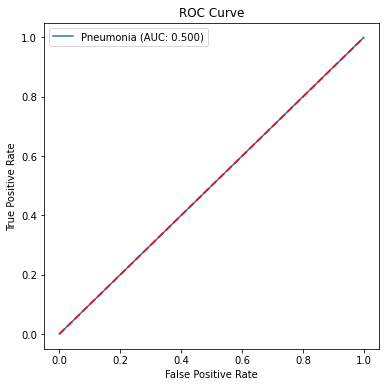

0.5

In [31]:
plot_auc(valY, pred_Y)

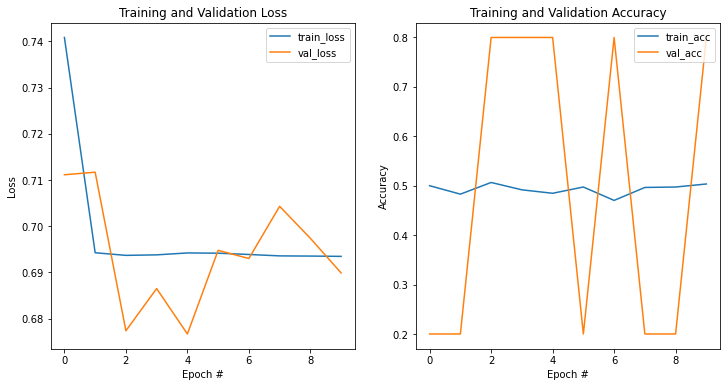

In [32]:
plot_history(history)

Max F1 score is 0.333
Threshold=0.486
Precision=0.200
Recall=1.000 


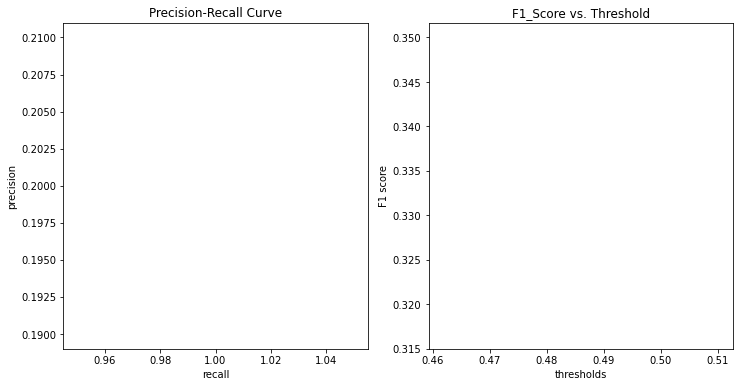

In [33]:
plot_precision_recall(valY, pred_Y)

In [34]:
preferred_threshold(valY, pred_Y, 'recall')

Choose a threshold that favors recall
Threshold=0.486
Precision=0.200
Recall=1.000
F1 score is 0.333
  
Accuracy at threshold that favors the recall: 0.800


In [35]:
preferred_threshold(valY, pred_Y, 'precision')

Choose a threshold that favors precision
Threshold=0.486
Precision=0.200
Recall=1.000
F1 score is 0.333
  
Accuracy at threshold that favors the precision: 0.800


In [37]:
tn, fp, fn, tp = confusion_matrix(valY, (pred_Y>0.333).astype(int)).ravel()
tn, fp, fn, tp

(0, 1144, 0, 286)

In [38]:
recall = tp/(tp+fn)
precision = tp/(tp+fp)
print(f'Recall: {recall}\nPrecision{precision}')

Recall: 1.0
Precision0.2


In [39]:
tn, fp, fn, tp = confusion_matrix(valY, (pred_Y>0.216).astype(int)).ravel()
tn, fp, fn, tp

(0, 1144, 0, 286)

In [40]:
recall = tp/(tp+fn)
precision = tp/(tp+fp)
print(f'Recall: {recall}\nPrecision{precision}')

Recall: 1.0
Precision0.2


In [41]:
## Just save model architecture to a .json:
model_json = model.to_json()
with open(f"model{experiment}.json", "w") as json_file:
    json_file.write(model_json)

### Model 2 
No LR reduce + one additional dense layer (516) followed by a dropout layer 0.3

In [42]:
def build_model2(include_top=False, input_shape=(224, 224, 3), layer_of_interest='block5_pool', finetune=15):

    base_model = VGG16(include_top=include_top,
                       weights='imagenet',
                       input_shape=input_shape)

    if finetune > 0:
        for layer in base_model.layers[0:finetune]:
            layer.trainable = False
    else:
        for layer in base_model.layers:
            layer.trainable = True

    transfer_layer = base_model.get_layer(layer_of_interest)
    transfer_output = transfer_layer.output

    x = Flatten()(transfer_output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(1, activation='sigmoid')(x)

    model = Model(base_model.input, x)
    model.compile(optimizer=Adam(lr=1e-4),
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy'])
    model.summary()

    for l in model.layers:
        print('Layer {} Trainable {}'.format(l.name, l.trainable))

    return model


model2 = build_model2()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [43]:
experiment = 2

# callbacks
checkpoint_path2="{}_model{}.best.hdf5".format('xray_class', experiment)

checkpoint = ModelCheckpoint(checkpoint_path2, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_weights_only = True)

early = EarlyStopping(monitor='val_loss', 
                      mode='min', 
                      patience=3)

reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=1e-6)

# metrics = Metrics()

callbacks_list = [checkpoint, early, reduceLR]

In [44]:
history2 = model2.fit_generator(train_gen, 
                              validation_data = (valX, valY), 
                              epochs = 20, 
                              callbacks = callbacks_list)

Epoch 1/20
143/143 [==============================] - 77s 537ms/step - loss: 0.7159 - binary_accuracy: 0.4961 - val_loss: 0.6581 - val_binary_accuracy: 0.7846

Epoch 00001: val_loss improved from inf to 0.65805, saving model to xray_class_model2.best.hdf5
Epoch 2/20
143/143 [==============================] - 72s 504ms/step - loss: 0.6904 - binary_accuracy: 0.5363 - val_loss: 0.6347 - val_binary_accuracy: 0.6315

Epoch 00002: val_loss improved from 0.65805 to 0.63470, saving model to xray_class_model2.best.hdf5
Epoch 3/20
143/143 [==============================] - 72s 502ms/step - loss: 0.6904 - binary_accuracy: 0.5424 - val_loss: 0.6529 - val_binary_accuracy: 0.7629

Epoch 00003: val_loss did not improve from 0.63470
Epoch 4/20
143/143 [==============================] - 72s 504ms/step - loss: 0.6773 - binary_accuracy: 0.5826 - val_loss: 0.6690 - val_binary_accuracy: 0.5972

Epoch 00004: val_loss did not improve from 0.63470
Epoch 5/20
143/143 [==============================] - 71s 499m

In [45]:
model2.load_weights(checkpoint_path2)
pred_Y2 = model2.predict(valX, verbose = True)


1430/1430 [==============================] - 13s 9ms/step


In [46]:
predictions2 = pd.DataFrame(
    {'Label': test_gen.labels, 'Prediction': pd.Series(pred_Y2.flatten().tolist())})
predictions2.to_csv(f'model{experiment}_prediction.csv')
predictions2.head()


,Label,Prediction
0,1,0.398649
1,1,0.449399
2,1,0.540830
3,1,0.722714
4,1,0.263777


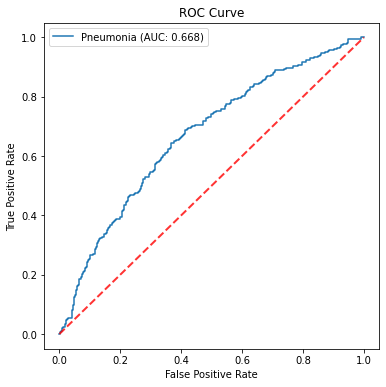

0.667984987040931

In [47]:
plot_auc(valY, pred_Y2)

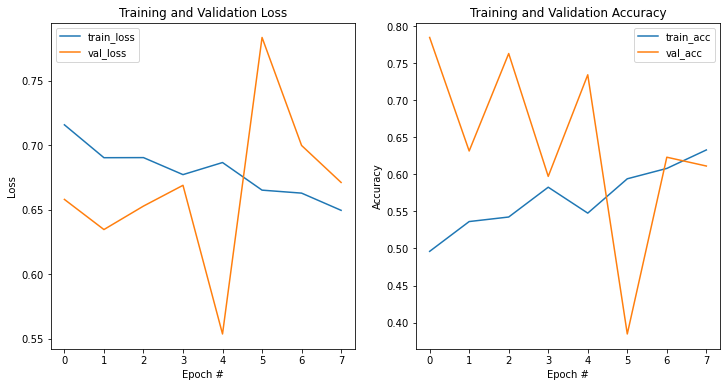

In [48]:
plot_history(history2)

Max F1 score is 0.413
Threshold=0.395
Precision=0.304
Recall=0.643 


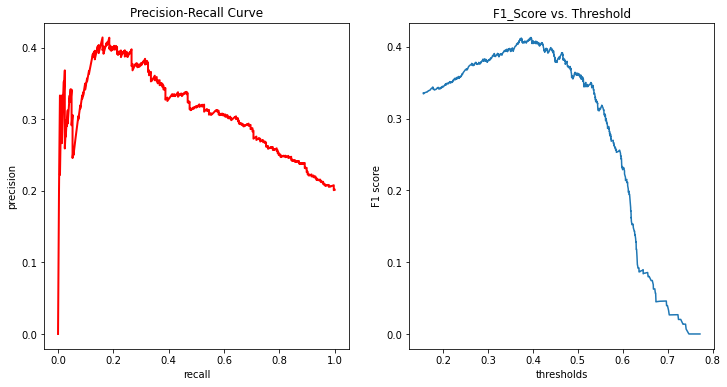

In [49]:
plot_precision_recall(valY, pred_Y2)

In [50]:
preferred_threshold(valY, pred_Y2, 'recall')

Choose a threshold that favors recall
Threshold=0.302
Precision=0.250
Recall=0.801
F1 score is 0.381
  
Accuracy at threshold that favors the recall: 0.200


In [51]:
preferred_threshold(valY, pred_Y2, 'precision')

Choose a threshold that favors precision
Threshold=0.602
Precision=0.414
Recall=0.161
F1 score is 0.232
  
Accuracy at threshold that favors the precision: 0.800


In [52]:
#tn, fp, fn, tp
confusion_matrix(valY, (pred_Y2>0.395).astype(int)).ravel()

array([723, 421, 102, 184])

In [53]:
confusion_matrix(valY, (pred_Y2>0.302).astype(int)).ravel()

array([457, 687,  57, 229])

In [54]:
model2_json = model2.to_json()
with open(f"exp2_model.json", "w") as json_file:
    json_file.write(model2_json)

### Model 3

In [55]:
def build_model3(include_top=False, input_shape=(224, 224, 3), layer_of_interest='block5_pool', finetune=15):

    base_model = VGG16(include_top=include_top,
                       weights='imagenet',
                       input_shape=input_shape)

    if finetune > 0:
        for layer in base_model.layers[0:finetune]:
            layer.trainable = False
    else:
        for layer in base_model.layers:
            layer.trainable = True

    transfer_layer = base_model.get_layer(layer_of_interest)
    transfer_output = transfer_layer.output

    x = Flatten()(transfer_output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(1, activation='sigmoid')(x)

    model = Model(base_model.input, x)
    model.compile(optimizer=Adam(lr=1e-4),
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy'])
    model.summary()

    for l in model.layers:
        print('Layer {} Trainable {}'.format(l.name, l.trainable))

    return model


model3 = build_model3()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [56]:
experiment = 3

# callbacks
checkpoint_path3 = "{}_model{}.best.hdf5".format('xray_class', experiment)

checkpoint = ModelCheckpoint(checkpoint_path3,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             save_weights_only=True)

early = EarlyStopping(monitor='val_loss',
                      mode='min',
                      patience=5)

reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                             patience=5, min_lr=1e-6)

# metrics = Metrics()

callbacks_list = [checkpoint, early, reduceLR]


In [57]:
history3 = model3.fit_generator(train_gen,
                                validation_data=(valX, valY),
                                epochs=20,
                                callbacks=callbacks_list)


Epoch 1/20
143/143 [==============================] - 77s 541ms/step - loss: 0.7403 - binary_accuracy: 0.5127 - val_loss: 0.6928 - val_binary_accuracy: 0.5007

Epoch 00001: val_loss improved from inf to 0.69276, saving model to xray_class_model3.best.hdf5
Epoch 2/20
143/143 [==============================] - 73s 508ms/step - loss: 0.6952 - binary_accuracy: 0.4969 - val_loss: 0.6855 - val_binary_accuracy: 0.7972

Epoch 00002: val_loss improved from 0.69276 to 0.68546, saving model to xray_class_model3.best.hdf5
Epoch 3/20
143/143 [==============================] - 72s 503ms/step - loss: 0.6927 - binary_accuracy: 0.5210 - val_loss: 0.6884 - val_binary_accuracy: 0.6958

Epoch 00003: val_loss did not improve from 0.68546
Epoch 4/20
143/143 [==============================] - 72s 504ms/step - loss: 0.6913 - binary_accuracy: 0.5358 - val_loss: 0.6984 - val_binary_accuracy: 0.4930

Epoch 00004: val_loss did not improve from 0.68546
Epoch 5/20
143/143 [==============================] - 72s 502m

In [58]:
model3.load_weights(checkpoint_path3)
pred_Y3 = model3.predict(valX, verbose=True)


1430/1430 [==============================] - 13s 9ms/step


In [59]:
predictions3 = pd.DataFrame(
    {'Label': test_gen.labels, 'Prediction': pd.Series(pred_Y3.flatten().tolist())})
predictions3.to_csv(f'model{experiment}_prediction.csv')
predictions3.head()


,Label,Prediction
0,1,0.496816
1,1,0.494124
2,1,0.430733
3,1,0.500226
4,1,0.227748


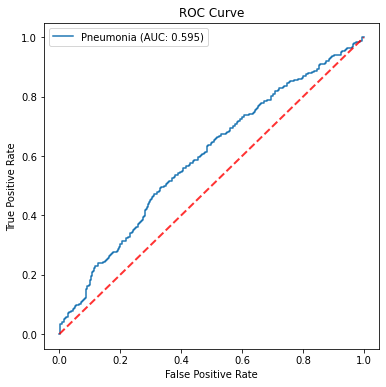

0.5946256540662135

In [60]:
plot_auc(valY, pred_Y3)

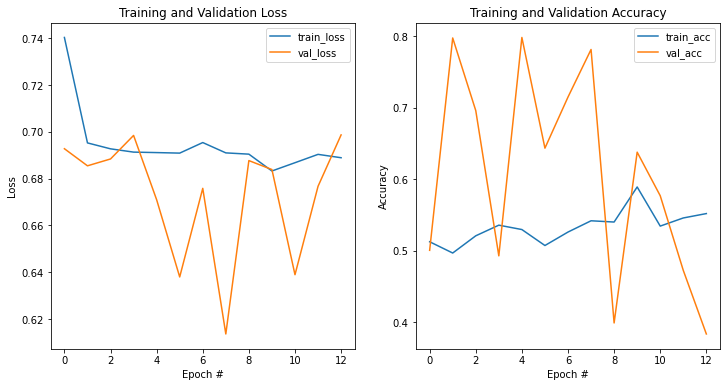

In [61]:
plot_history(history3)

Max F1 score is 0.356
Threshold=0.443
Precision=0.243
Recall=0.664 


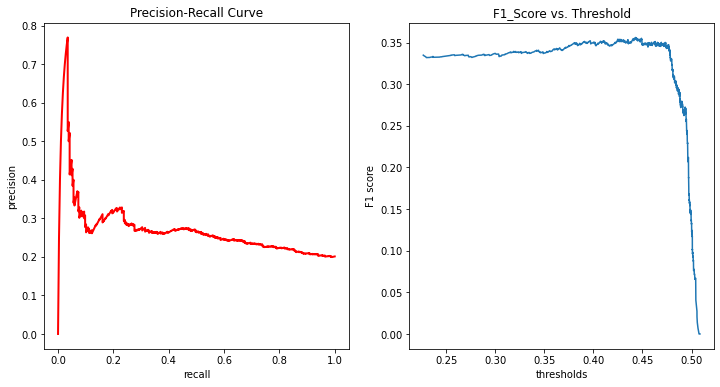

In [62]:
plot_precision_recall(valY, pred_Y3)

In [63]:
preferred_threshold(valY, pred_Y3, 'recall')

Choose a threshold that favors recall
Threshold=0.401
Precision=0.223
Recall=0.801
F1 score is 0.349
  
Accuracy at threshold that favors the recall: 0.200


In [64]:
preferred_threshold(valY, pred_Y3, 'precision')

Choose a threshold that favors precision
Threshold=0.504
Precision=0.769
Recall=0.035
F1 score is 0.067
  
Accuracy at threshold that favors the precision: 0.800


In [65]:
#tn, fp, fn, tp
tn, fp, fn, tp = confusion_matrix(valY, (pred_Y3>0.41).astype(int)).ravel()
tn, fp, fn, tp

(385, 759, 63, 223)

In [66]:
recall = tp/(tp+fn)
precision = tp/(tp+fp)
print(f'Recall: {recall}\nPrecision{precision}')

Recall: 0.7797202797202797
Precision0.22708757637474541


In [67]:
model3_json = model3.to_json()
with open(f"exp3_model.json", "w") as json_file:
    json_file.write(model3_json)


### Final Validation
Model2 is selected because its AUROC score is the highest among the three models.     
Threshold used for validation is `0.501` to optimize the recall rate, for this is more meaningful for its negatie predictive value. When the model favors precision rate, the output recall and associated F1 score are too low to draw any meaningful conclusion. 

In [70]:
testY = pred_Y2
YOUR_THRESHOLD = 0.302

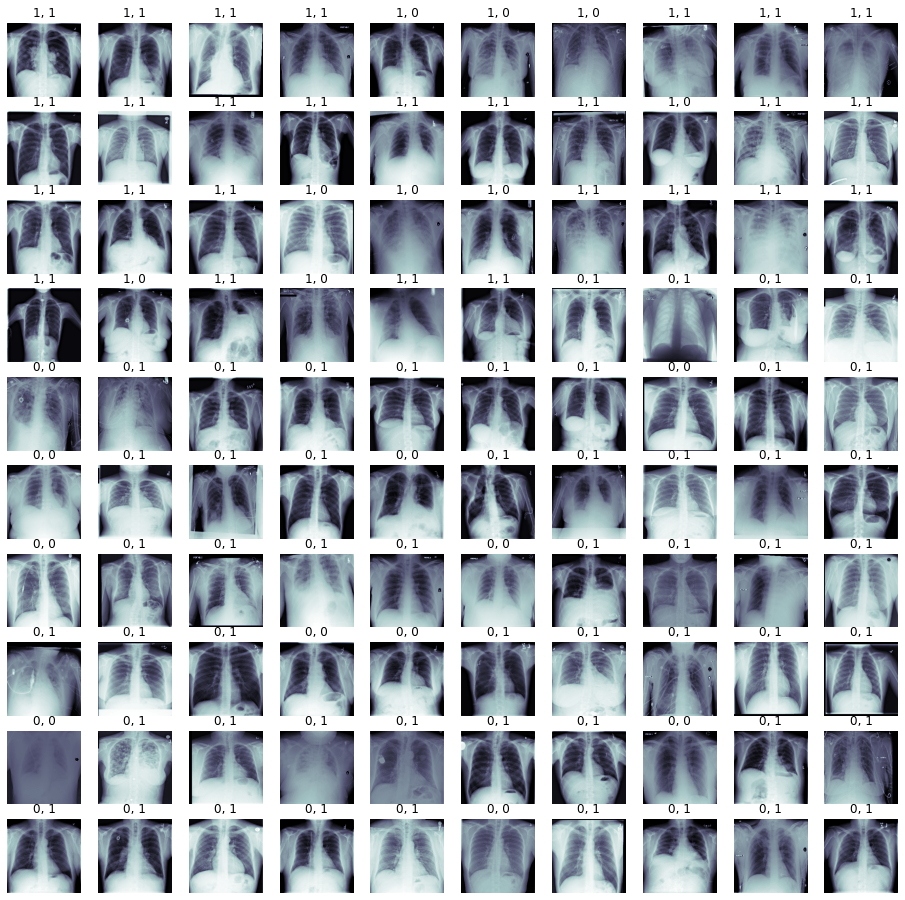

In [71]:
# sample comparisons between predictions and ground truth.

fig, m_axs = plt.subplots(10, 10, figsize=(16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[250:350], valY[250:350], m_axs.flatten()):
    c_ax.imshow(c_x[:, :, 0], cmap='bone')
    if c_y == 1:
        if testY[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if testY[i] > YOUR_THRESHOLD:
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i = i+1
